In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import argparse
from utils import cfh, logger, Data, bool_ext, checkCorrelations, generate_masks_from_ppi
import os
import argparse
import random
from utils import cfh, logger, Data, bool_ext, checkCorrelations, generate_masks_from_ppi
from biomodels import BioCitrus
import torch
import numpy as np
import sys
from biomodels import weightConstraint
from utils import logger, get_minibatch, evaluate, EarlyStopping, shuffle_data
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore") ##This is bad but temporary

/ihome/hosmanbeyoglu/kor11/.virtualenvs/deepbio/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--input_dir", 
    help="directory of input files", 
    type=str, 
    default="./data"
)
parser.add_argument(
    "--output_dir",
    help="directory of output files",
    type=str,
    default="./output",
)

parser.add_argument(
    "--algo", 
    help="clustering algorithm to use on the portein-protein network (DPCLUS, MCODE, COACH)", 
    type=str, 
    default='COACH'
)


parser.add_argument(
    "--learning_rate", 
    help="learning rate for Adam", 
    type=float, 
    default=1e-2
)
parser.add_argument(
    "--max_iter", 
    help="maximum number of training iterations", 
    type=int, 
    default=300
)
parser.add_argument(
    "--max_fscore",
    help="Max F1 score to early stop model from training",
    type=float,
    default=0.7
)
parser.add_argument(
    "--batch_size", 
    help="training batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_batch_size", 
    help="test batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_inc_size",
    help="increment interval size between log outputs",
    type=int,
    default=256
)
parser.add_argument(
    "--dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.1
)

parser.add_argument(
    "--weight_decay", 
    help="coefficient of l2 regularizer", 
    type=float, 
    default=1e-2
)
parser.add_argument(
    "--activation",
    help="activation function used in hidden layer",
    type=str,
    default="tanh",
)
parser.add_argument(
    "--patience", 
    help="earlystopping patience", 
    type=int, 
    default=20
)
parser.add_argument(
    "--mask01",
    help="wether to ignore the float value and convert mask to 01",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--gep_normalization", 
    help="how to normalize gep", 
    type=str, 
    default="scaleRow"
)

parser.add_argument(
    "--cancer_type",
    help="whether to use cancer type or not",
    type=bool_ext,
    default=False,
)
parser.add_argument(
    "--train_model",
    help="whether to train model or load model",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--dataset_name",
    help="the dataset name loaded and saved",
    type=str,
    default="dataset_CITRUS",
)
parser.add_argument(
    "--tag", 
    help="a tag passed from command line", 
    type=str, 
    default=""
)
parser.add_argument(
    "--run_count", 
    help="the count for training", 
    type=str, 
    default="1"
)

parser.add_argument(
    "--ppi_weights", 
    help="", 
    type=bool_ext, 
    default=False
)

parser.add_argument(
    "--verbose", 
    help="", 
    type=bool_ext, 
    default=False
)

parser.add_argument(
    "--constrain", 
    help="force weight and biases to be strictly non-negative", 
    type=bool_ext, 
    default=False
)

parser.add_argument(
    "--biases", 
    help="enable all nn.Linear biases", 
    type=bool_ext, 
    default=True
)

parser.add_argument(
    "--sparse", 
    help="only use SIGNOR data, resulting in sparser connections", 
    type=bool_ext, 
    default=False
)

args = parser.parse_args([])

data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv'
)

train_set, test_set = data.get_train_test()
args.gep_size = train_set['gep'].shape[1]
args.tf_gene = data.gene_tf_sga.values.T
args.can_size = len(np.unique(data.cancer_types))


sga_mask, sga_weights, tf_mask, tf_weights = generate_masks_from_ppi(sga = data.sga_sga, tf = data.gene_tf_sga, clust_algo=args.algo, sparse=args.sparse)


sga_mask = sga_mask
sga_weights = sga_weights.t()
tf_mask = tf_mask.t()
tf_weights = tf_weights


(utils.py : 611) -     INFO | Loading data files
(utils.py : 371) -    DEBUG | Loaded 352251 edges from the SIGNOR and SNAP Networks
(utils.py : 395) -    DEBUG | Using induced overlap network with 10270 common genes
(utils.py : 489) -     INFO | Using dense COACH clustering algorithm
(utils.py : 550) -     INFO | Generated sga-ppi mask with 3862 clusters and 6533 edges
(utils.py : 569) -     INFO | Generated ppi-tf mask with 3862 clusters and 268 edges


In [3]:
model = BioCitrus(
    args = args, 
    sga_ppi_mask = sga_mask, 
    ppi_tf_mask = tf_mask, 
    sga_ppi_weights = None, 
    ppi_tf_weights = None,
    enable_bias = True
)

(biomodels.py : 103) -    DEBUG | sga_layer.0.mask | False | (3862, 11998)
(biomodels.py : 103) -    DEBUG | sga_layer.0.weight | True | (3862, 11998)
(biomodels.py : 103) -    DEBUG | tf_layer.0.mask | False | (320, 3862)
(biomodels.py : 103) -    DEBUG | tf_layer.0.weight | True | (320, 3862)
(biomodels.py : 103) -    DEBUG | tf_layer.0.bias | True | (320,)
(biomodels.py : 103) -    DEBUG | gep_output_layer.weight | True | (5541, 320)
(biomodels.py : 105) -    DEBUG | Constraints Enabled: False
(biomodels.py : 106) -    DEBUG | Biases Enabled: True


In [4]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients

In [5]:
model = BioCitrus(
    args = args, 
    sga_ppi_mask = sga_mask, 
    ppi_tf_mask = tf_mask, 
    sga_ppi_weights = None, 
    ppi_tf_weights = None,
    enable_bias = args.biases
)

model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

(biomodels.py : 103) -    DEBUG | sga_layer.0.mask | False | (3862, 11998)
(biomodels.py : 103) -    DEBUG | sga_layer.0.weight | True | (3862, 11998)
(biomodels.py : 103) -    DEBUG | tf_layer.0.mask | False | (320, 3862)
(biomodels.py : 103) -    DEBUG | tf_layer.0.weight | True | (320, 3862)
(biomodels.py : 103) -    DEBUG | tf_layer.0.bias | True | (320,)
(biomodels.py : 103) -    DEBUG | gep_output_layer.weight | True | (5541, 320)
(biomodels.py : 105) -    DEBUG | Constraints Enabled: False
(biomodels.py : 106) -    DEBUG | Biases Enabled: True


<All keys matched successfully>

In [6]:
model.eval()

BioCitrus(
  (sga_layer): Sequential(
    (0): MaskedBioLayer(input_features=11998, output_features=3862, bias=False)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
  )
  (tf_layer): Sequential(
    (0): MaskedBioLayer(input_features=3862, output_features=320, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
  )
  (gep_output_layer): Linear(in_features=320, out_features=5541, bias=False)
  (criterion): MSELoss()
)

In [7]:
breast_cancer_genes = list(set(data.gep_sga.columns).intersection(
    set(
        ['BRCA1', 'BRCA2', 'CHEK2', 'ATM', 'PALB2', 'BRIP1',
        'ESR1', 'NRIP1', 'TP53', 'MYC', 'PIK3CA', 'NOTCH2', 'CCND1', 'FGF', 'CDKN2A'
        'CDKN2B', 'CASP8', 'TERT', 'PAX9']
    )))

breast_cancer_genes

['BRCA2',
 'PALB2',
 'TERT',
 'CHEK2',
 'BRIP1',
 'MYC',
 'PIK3CA',
 'ATM',
 'ESR1',
 'BRCA1',
 'CCND1',
 'TP53',
 'CASP8',
 'NOTCH2']

In [8]:
X = torch.tensor(test_set['sga'])
X.shape

torch.Size([1974, 11998])

In [9]:
Y = test_set['gep']
Y.shape

(1974, 5541)

In [10]:
attr_scores = []
ig = IntegratedGradients(model)
pbar = tqdm(total= len(breast_cancer_genes))
for g in breast_cancer_genes:
    pbar.set_description(f'{g} ')
    idx = list(data.gep_sga.columns).index(g)
    ig_attr_test = ig.attribute(X[:500], target=[idx]*len(X[:500]))
    ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    attr_scores.append(ig_attr_test_norm_sum)
    pbar.update()

pbar.close()

NOTCH2 : 100%|██████████| 14/14 [04:12<00:00, 18.06s/it]


In [11]:
df = pd.DataFrame(np.array(attr_scores))
df.index = breast_cancer_genes
df.columns = data.alterations
df = df.T

In [12]:
d = df.loc[df.var(1) != 0]

<AxesSubplot:>

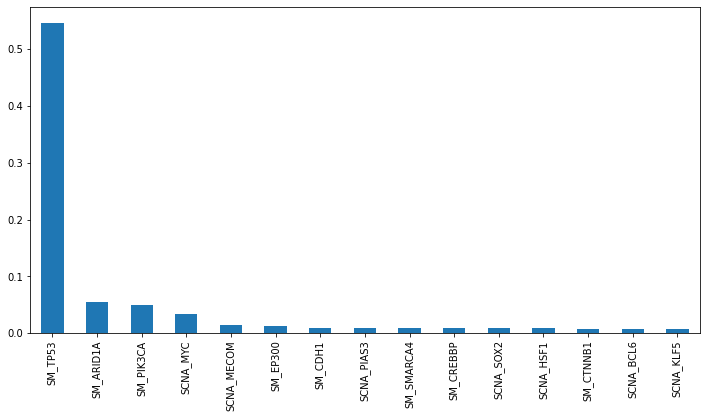

In [15]:
d['PIK3CA'].sort_values(ascending=False)[:15].plot(kind='bar', figsize=(12,6))

<AxesSubplot:>

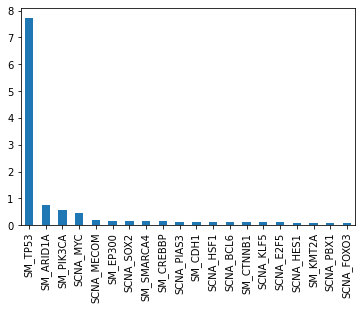

In [17]:
d.sum(1).sort_values(ascending=False)[:20].plot(kind='bar')

In [21]:
lc = LayerConductance(model, model.gep_output_layer)

In [22]:
model.gep_output_layer.weight.shape

torch.Size([5541, 320])

In [23]:
a = lc.attribute(X[:500], n_steps=100, attribute_to_layer_input=True, target=[5056]*len(X[:500]))

In [24]:
a.shape

torch.Size([500, 320])

In [25]:
ig_attr_test_sum = a.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

In [26]:
ig_attr_test_norm_sum.shape

(320,)

In [27]:
with open('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/COACH_clusters_large.txt', "r") as fh:
        lines = fh.readlines()
        clusterindex_to_genes = {}
        for i, c in enumerate(lines):
            clustlist = c.strip().split(" ")
            if len(c) == 0:
                continue
            clusterindex_to_genes[i] = clustlist 

from collections import defaultdict
gene_to_clusterindices = defaultdict(list) ## 'MAPK1':[0, 75, 129, 373]

## Create mapping between genes and the protein clusters
for c in clusterindex_to_genes.keys():
    for g in clusterindex_to_genes[c]:
        gene_to_clusterindices[g].append(c)  

In [31]:
data.gene_tf_sga.columns.shape

(320,)

In [28]:
g = np.array(data.gene_tf_sga.columns)[np.where(ig_attr_test_norm_sum != 0)[0]]
at = ig_attr_test_norm_sum[np.where(ig_attr_test_norm_sum != 0)[0]]

In [29]:
at.shape, g.shape

((40,), (40,))

In [30]:
df = pd.DataFrame([g, at]).T
df.sort_values(by=1, ascending=False)[:15]

,0,1
31,SMARCC1,0.230398
17,FOXO3,0.180637
37,E2F1,0.163905
20,RUNX2,0.135669
5,SMARCC2,0.110729
21,FLI1,0.0564972
13,NFE2L2,0.0509953
7,FOXO1,0.0495939
15,RUNX3,0.0110788
2,TCF7L2,0.00878923


In [40]:
for i in clusterindex_to_genes[2118]:
    print(i)

KLF5
GRIP1
TGIF2
EP300
VIM
YY1
RUNX1
SAP130
SKIL
KDM5C
MAFK
ACTB
SUV39H1
SMARCA4
PIN1
ZEB1
TGIF1
SMAD3
HIPK2
FOXG1
SMARCC2
CEBPA
HDAC5
FOXO3
HIF1A
ZBTB16
EID2
ZMYM2
SMARCC1
CDKN1A
ARID1A
RUNX3
MBD1
SMAD7
CTNNB1
FOXP3
HSPA8
BRCA2
SMAD1
TP73
DACH1
HDAC1
TP53
CEBPD
RBL1
PLAGL1
JUN
SMAD5
PPP2R1A
ESR1
BUB3
RELA
PML
DDX5
SMAD4
LEF1
NOTCH1
SMAD2
PIAS3
MECOM
CREBBP
ATF3
SIN3A
GLI3
NFYC
FLI1
BACH1
MAPK8
MAPK9
ZEB2
ZMYND11
CEBPB
PPARG
RUNX2
VDR
NCOR1
AR
E2F5
CDH1
BRCA1
E2F4
SKI
MYC
MAPK14
MEN1
HSPA4
PIK3CA
NR3C1
